In [7]:
from utils.functions import get_path, search_files, get_filename
from utils.config import (
    CBIS_DDSM_CONVERTED_DATA_PATH, CBIS_DDSM_PREPROCESSED_DATA_PATH, CBIS_DDSM_DB_PATH, MIAS_CONVERTED_DATA_PATH,
    MIAS_PREPROCESSED_DATA_PATH, INBREAST_CONVERTED_DATA_PATH, INBREAST_PREPROCESSED_DATA_PATH,
    INBREAST_DB_XML_ROI_PATH
)

from typing import io

import cv2
import plistlib
import os
import pydicom

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

root_path = r'C:\Users\USUARIO\Desktop\Master Data Science\TFM\Code\src'
% matplotlib inline

UsageError: Line magic function `%` not found.


#### Análisis set de datos CBIS-DDSM

In [8]:
# Se obtiene el número de imagenes del dataset CBIS-DDSM
l = []
for file in search_files(get_path(root_path, CBIS_DDSM_CONVERTED_DATA_PATH, 'FULL', create=False), ext='png', in_subdirs=False):
    l.append([get_filename(file)])

cbis_df = pd.DataFrame(l, columns=['FILE_NAME'])

In [9]:
# Se obtienen las mascaras convertidas
l = []
for file in search_files(get_path(root_path, CBIS_DDSM_CONVERTED_DATA_PATH, 'MASK', create=False), ext='png', in_subdirs=False):
    l.append([get_filename(file)])

cbis_mask_df = pd.DataFrame(l, columns=['MASK_FILE_NAME'])

In [10]:
# Imagenes que no tienen mascara convertida
cbis_df[~cbis_df.FILE_NAME.isin(cbis_mask_df.MASK_FILE_NAME)]

,FILE_NAME


Todas las imagenes tienen máscara convertida.

In [11]:
# Se obtienen las mascaras procesadas
l = []
for file in search_files(get_path(root_path, CBIS_DDSM_PREPROCESSED_DATA_PATH, 'MASK', create=False), ext='png', in_subdirs=False):
    l.append([get_filename(file)])

cbis_mask_df_proc = pd.DataFrame(l, columns=['MASK_FILE_NAME'])

In [12]:
# Imagenes que no tienen mascara procesada
cbis_df[~cbis_df.FILE_NAME.isin(cbis_mask_df_proc.MASK_FILE_NAME)]

,FILE_NAME
189,Mass-Test_P_01090_RIGHT_MLO
387,Mass-Training_P_00092_RIGHT_CC
685,Mass-Training_P_00596_RIGHT_CC
759,Mass-Training_P_00720_RIGHT_MLO
765,Mass-Training_P_00730_RIGHT_CC


Existen 5 imagenes cuya mascara no se ha procesado.

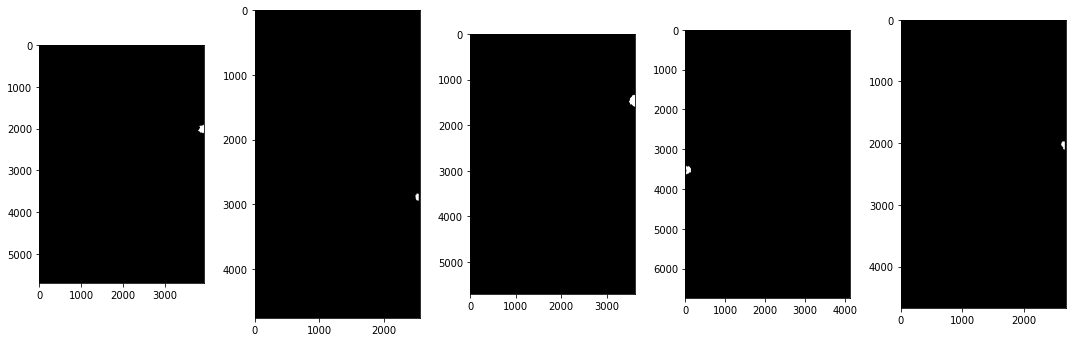

In [13]:
fig, ax = plt.subplots(1, 5, figsize=(15, 7))

for file, axes in zip(cbis_df[~cbis_df.FILE_NAME.isin(cbis_mask_df_proc.MASK_FILE_NAME)].FILE_NAME.values.tolist(), ax.flatten()):

    axes.imshow(cv2.imread(get_path(root_path, CBIS_DDSM_CONVERTED_DATA_PATH, 'MASK', f'{file}.png')))

fig.tight_layout()

Este error es debido a que **la patología se encuentra en uno de los extremos del seno y este es recortado.**

In [14]:
# Se obtiene el número de carpetas con _N de cada imagen para saber el número de máscaras individuales sin solapar
cbis_mask_ori = pd.DataFrame(
    data=search_files(file=f'{root_path}\\{CBIS_DDSM_DB_PATH}\\Mass-*_[0-9]', ext='dcm', in_subdirs=True),
    columns=['MASK_FILEPATH']
)
cbis_mask_ori.loc[:, 'FILE_NAME'] = cbis_mask_ori.MASK_FILEPATH.apply(lambda x: "_".join(x.split(os.sep)[-4].split("_")[:-1]))

In [15]:
# Se suprimen los registros que no pertenecen al dataset debido a que tienen una patología benign-without-callback.
cbis_mask_ori.drop(index=cbis_mask_ori[~cbis_mask_ori.FILE_NAME.isin(cbis_roi.FILE_NAME)].index, inplace=True)

In [16]:
# Se comprueba para cada archivo si se trata de una máscara o no
cbis_mask_ori.loc[:, 'IS_MASK'] = cbis_mask_ori.MASK_FILEPATH.apply(
    lambda x: 1 if len(np.unique(pydicom.dcmread(x).pixel_array)) == 2 else 0)

In [17]:
# Se obtienen los crops realizados en el dataframe.
cbis_roi = pd.DataFrame(
    data=search_files(file=f'{root_path}\\{CBIS_DDSM_PREPROCESSED_DATA_PATH}\\CROP\\CONF0', ext='png', in_subdirs=False),
    columns=['ROI_FILEPATH']
)
cbis_roi.loc[:, 'FILE_NAME'] = cbis_roi.ROI_FILEPATH.apply(lambda x: "_".join(get_filename(x).split('_')[1:-1]))
cbis_roi.loc[:, 'IMG_SIZE'] = cbis_roi.ROI_FILEPATH.apply(lambda x: cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2GRAY).shape)

In [20]:
# Se obtiene el número de máscaras total. Este, debe de coincidir con el número de rois obtenidos
cbis_roi_analize = cbis_mask_ori.groupby('FILE_NAME', as_index=False).IS_MASK.sum()

print(f'Existen un total de {len(cbis_roi) - cbis_roi_analize.IS_MASK.sum()} discrepancias.')

Existen un total de -2 discrepancias.


In [21]:
# Se comprueba cuales pueden ser los errores a partir del número de recortes por imagen y el número de máscaras por imagen
# Estos, deberían de coincidir.
check_rois = pd.merge(
    left=cbis_roi.FILE_NAME.value_counts().reset_index().rename(columns={'index': 'FILE_NAME', 'FILE_NAME': 'N_CROPS'}),
    right=cbis_roi_analize.rename(columns={'IS_MASK': 'N_MASK'}),
    on='FILE_NAME',
    how='left'
)
check_rois.loc[:, 'DIFF']=check_rois.N_CROPS - check_rois.N_MASK
check_rois[check_rois.DIFF != 0].DIFF.sum()

# Las imagenes que contienen cortes adicionales son:
errors = pd.merge(left=cbis_roi, right=check_rois[check_rois.DIFF != 0], on='FILE_NAME')
errors.loc[:, 'AREA'] = errors.IMG_SIZE.str[1].astype(int) * errors.IMG_SIZE.str[0].astype(int)
errors.loc[:, 'LIMIT'] = errors.sort_values('AREA', ascending=False).groupby('FILE_NAME').cumcount() + 1

errors[errors.LIMIT != errors.N_MASK]

,ROI_FILEPATH,FILE_NAME,IMG_SIZE,N_CROPS,N_MASK,DIFF,AREA,LIMIT
0,C:\Users\USUARIO\Desktop\Master Data Science\T...,Mass-Training_P_00778_RIGHT_MLO,"(402, 314)",1,2,-1,126228,1
1,C:\Users\USUARIO\Desktop\Master Data Science\T...,Mass-Training_P_00802_LEFT_MLO,"(1082, 2130)",1,3,-2,2304660,1
2,C:\Users\USUARIO\Desktop\Master Data Science\T...,Mass-Training_P_01262_RIGHT_CC,"(164, 80)",3,2,1,13120,3
3,C:\Users\USUARIO\Desktop\Master Data Science\T...,Mass-Training_P_01262_RIGHT_CC,"(674, 346)",3,2,1,233204,1


###### Conclusiones:

El total de máscaras individuales son 1560. Al agruparlas, se obtienen 1473 máscaras.

Los CROPS del dataset son 1553 y no 1560 porque:
- 5 rois borrados por el crop derecho de la mascara. (-5 samples)
- 01262_RIGHT_CC: Se generan 3 rois debido al crop derecho de la mascara. Separa una única región en 2. (+1 sample)
- 00802_LEFT_MLO: Las 3 máscaras se solapan, resultando un único ROI. (-2 samples)
- 00778_RIGHT_MLO: Las 2 máscaras se solapan, resultando un único ROI. (-1 sample)

Las imagenes y las máscaras son 1468 y no 1473 porque:
- 5 rois borrados antriormente por el crop derecho de la mascara. (-5)


#### Análisis set de datos InBreast

El dataset no presenta duplicidades ni patologías ambiguas. **El número de muestras totales es de 88**

In [90]:
# Lectura del dataframe
path = r"C:\Users\USUARIO\Desktop\Master Data Science\TFM\Code\data\00_RAW\INBreast\INbreast.xls"
inbreast_df = pd.read_excel(path, skipfooter=2)

# Se eliminan imagenes sin patología y que no son de masas
inbreast_df.drop(
    index=inbreast_df[(inbreast_df['Mass '].isnull()) | (inbreast_df['Bi-Rads'].isin([1, 3, '4a']))].index, 
    inplace=True
)

print(f'Número de imagenes en el dataset {len(inbreast_df)}')

Número de imagenes en el dataset 88


In [128]:
# Se recuperan los rois de los XML.
roi_xml_inbreast = []
for f in search_files(INBREAST_DB_XML_ROI_PATH, ext='xml', in_subdirs=False):
    plist_dict = plistlib.load(open(f, 'rb'), fmt=plistlib.FMT_XML)['Images'][0]
    for roi in plist_dict['ROIs']:
        if (roi['Name'] in ['Mass']):
            roi_xml_inbreast.append([get_filename(f)])

roi_xml_inbreast_df = pd.DataFrame(roi_xml_inbreast, columns=['FILE_NAME']).FILE_NAME.value_counts()\
    .reset_index().rename(columns={'index': 'FILE_NAME', 'FILE_NAME': 'N_MASKS'})

print(f'Total de máscaras en inbreast {roi_xml_inbreast_df.N_MASKS.sum()}')

roi_xml_inbreast_df

Total de máscaras en inbreast 116


,FILE_NAME,N_MASKS
0,51049107,3
1,20586908,2
2,22613770,2
3,22580341,2
4,22579730,2
...,...,...
102,22613702,1
103,22613650,1
104,22580732,1
105,22580706,1


In [129]:
# Se comprueba si todas las imagenes tienen máscara.
inbreast_df[~inbreast_df['File Name'].astype(str).isin(roi_xml_inbreast_df.FILE_NAME.astype(str))]['File Name']

5    22614097
7    22614150
Name: File Name, dtype: int64

In [113]:
# Se comprueba el número de imagenes procesadas.
inbreast_img_processed = pd.DataFrame(
    search_files(file=f'{root_path}\\{INBREAST_PREPROCESSED_DATA_PATH}\\FULL', ext='png', in_subdirs=False), 
    columns=['FILEPATH']
)

inbreast_img_processed.loc[:, 'FILE_NAME'] = inbreast_img_processed.FILEPATH.apply(lambda x: get_filename(x))
print(f'Total de imagenes procesadas {len(inbreast_img_processed)}')

Total de imagenes procesadas 88


El número de imagenes procesadas es de 88, pero en el dataset, únicamente existen 86 imagenes porque se descartan las que no tienen máscara.

In [112]:
# Se comprueba el número de máscaras procesadas
inbreast_mask_processed = pd.DataFrame(
    search_files(file=f'{root_path}\\{INBREAST_PREPROCESSED_DATA_PATH}\\MASK', ext='png', in_subdirs=False), 
    columns=['FILEPATH']
)

inbreast_mask_processed.loc[:, 'FILE_NAME'] = inbreast_mask_processed.FILEPATH.apply(lambda x: get_filename(x))
print(f'Total de mascaras procesadas {len(inbreast_mask_processed)}')

Total de mascaras procesadas 86


In [116]:
# Se comprueba el número de recortes
inbreast_roi_processed = pd.DataFrame(
    search_files(file=f'{root_path}\\{INBREAST_PREPROCESSED_DATA_PATH}\\CROP\\CONF0', ext='png', in_subdirs=False), 
    columns=['FILEPATH']
)

inbreast_roi_processed.loc[:, 'FILE_NAME'] = inbreast_roi_processed.FILEPATH.apply(
    lambda x: "_".join(get_filename(x).split("_")[1:-1]))
print(f'Total de mascaras procesadas {len(inbreast_roi_processed)}')

Total de mascaras procesadas 94


In [135]:
errors = pd.merge(
    left=inbreast_roi_processed.FILE_NAME.value_counts().reset_index().\
        rename(columns={'index': 'FILE_NAME', 'FILE_NAME': 'N_CROPS'}),
    right=roi_xml_inbreast_df,
    on='FILE_NAME',
    how='right'
)
errors.loc[:, 'pathology'] = errors.FILE_NAME.astype(str).\
    map(pd.read_excel(path, skipfooter=2, dtype=str).set_index('File Name').to_dict()['Bi-Rads'])

errors.loc[:, 'tipo'] = errors.FILE_NAME.astype(str).\
    map(pd.read_excel(path, skipfooter=2, dtype=str).set_index('File Name').to_dict()['Mass '])

errors[(errors.N_CROPS != errors.N_MASKS)]

,FILE_NAME,N_CROPS,N_MASKS,pathology,tipo
0,51049107,2.00,3,2,X
9,50994354,NaN,1,4a,X
18,24065584,NaN,1,4c,NaN
30,50994273,NaN,1,4a,X
40,51048765,NaN,1,3,X
41,51048738,NaN,1,3,X
48,50997515,NaN,1,4a,X
49,50997461,NaN,1,4a,X
53,22678646,NaN,1,3,X
55,22678694,NaN,1,3,X


###### Conclusiones:

El número de máscaras y de imagenes procesadas es de 86 y no de 88 porque:
- 2 muestras no contienen anotaciones en el XML.

El número de ROIs es de 94 y no de 116 porque:
- 20 recortes contienen patología 3 o 4a (-20)
- existe overlap en una muestra (51049107) (-1)
- La imagen 24065584 no está clasificada como masa en el excel

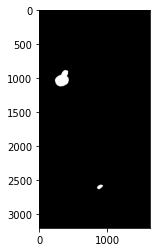

In [131]:
plt.imshow(cv2.imread(f'{root_path}\\{INBREAST_PREPROCESSED_DATA_PATH}\\MASK\\51049107.png'))

#### Análisis set de datos MIAS

El dataset presenta duplicidades y patologías ambiguas. **El número de muestras totales es de 74**

In [32]:
# Lectura del dataframe
path = r"C:\Users\USUARIO\Desktop\Master Data Science\TFM\Code\data\00_RAW\MIAS\Info.txt"
mias_df = pd.read_csv(
    path, sep=' ', skiprows=102, skipfooter=2, engine='python',
    names=['FILE_NAME', 'BREAST_TISSUE', 'ABNORMALITY_TYPE', 'PATHOLOGY', 'X_CORD', 'Y_CORD', 'RAD']
)

# Se realiza el limpiado de imagenes sin patología y abnormalidades distintas a masas
mias_df.drop(
    index=mias_df[(~mias_df.ABNORMALITY_TYPE.isin(['CIRC', 'SPIC', 'MISC', 'ASYM'])) | (mias_df.PATHOLOGY.isnull())].index, 
    inplace=True
)

print(f'Número de imagenes en el dataset {len(mias_df)}')

Número de imagenes en el dataset 74


In [33]:
mias_df[mias_df.FILE_NAME.duplicated()].FILE_NAME

5      mdb005
133    mdb132
146    mdb144
Name: FILE_NAME, dtype: object

In [37]:
ambiguous_pathology = mias_df.groupby(['FILE_NAME']).PATHOLOGY.nunique()
ambiguous_pathology[ambiguous_pathology > 1]

FILE_NAME
mdb144    2
Name: PATHOLOGY, dtype: int64

In [44]:
mias_df[mias_df[['X_CORD', 'Y_CORD', 'RAD']].applymap(lambda x: pd.to_numeric(x, errors='coerce')).isna().any(axis=1)].FILE_NAME

59    mdb059
Name: FILE_NAME, dtype: object

In [61]:
# Se comprueba el número de imagenes procesadas.
mias_img_processed = pd.DataFrame(
    search_files(file=f'{root_path}\\{MIAS_PREPROCESSED_DATA_PATH}\\FULL', ext='png', in_subdirs=False), 
    columns=['FILEPATH']
)

mias_img_processed.loc[:, 'FILE_NAME'] = mias_img_processed.FILEPATH.apply(lambda x: get_filename(x))

In [69]:
# Se comprueba el número de recortes
mias_roi_processed = pd.DataFrame(
    search_files(file=f'{root_path}\\{MIAS_PREPROCESSED_DATA_PATH}\\CROP\\CONF0', ext='png', in_subdirs=False), 
    columns=['FILEPATH']
)

mias_roi_processed.loc[:, 'FILE_NAME'] = mias_roi_processed.FILEPATH.apply(lambda x: "_".join(get_filename(x).split("_")[1:-1]))

In [71]:
# Se comprueba el número de recortes
mias_mask_processed = pd.DataFrame(
    search_files(file=f'{root_path}\\{MIAS_PREPROCESSED_DATA_PATH}\\MASK', ext='png', in_subdirs=False), 
    columns=['FILEPATH']
)

mias_mask_processed.loc[:, 'FILE_NAME'] = mias_mask_processed.FILEPATH.apply(lambda x: get_filename(x))

In [72]:
errors = pd.concat([
    mias_df[~mias_df.FILE_NAME.isin(mias_img_processed.FILE_NAME)].assign(DESC='IMG NO PROCESADA')[['DESC', 'FILE_NAME']],
    mias_df[~mias_df.FILE_NAME.isin(mias_roi_processed.FILE_NAME)].assign(DESC='ROI NO PROCESADO')[['DESC', 'FILE_NAME']],
    mias_df[~mias_df.FILE_NAME.isin(mias_mask_processed.FILE_NAME)].assign(DESC='MASK NO PROCESADA')[['DESC', 'FILE_NAME']],
])

errors.loc[:, 'MOTIVO'] = errors.FILE_NAME.map({
    'mdb059': 'no tiene localización de la patología',
    'mdb144': 'patología ambigua',
    'mdb005': '2 patologías',
    'mdb132': '2 patologías'
})
errors

,DESC,FILE_NAME,MOTIVO
59,IMG NO PROCESADA,mdb059,no tiene localización de la patología
145,IMG NO PROCESADA,mdb144,patología ambigua
146,IMG NO PROCESADA,mdb144,patología ambigua
59,ROI NO PROCESADO,mdb059,no tiene localización de la patología
59,MASK NO PROCESADA,mdb059,no tiene localización de la patología
145,MASK NO PROCESADA,mdb144,patología ambigua
146,MASK NO PROCESADA,mdb144,patología ambigua


In [73]:
print(f'{len(mias_img_processed)} imagenes procesadas')
print(f'{len(mias_mask_processed)} máscaras procesadas')
print(f'{len(mias_roi_processed)} rois procesados')

69 imagenes procesadas
69 máscaras procesadas
72 rois procesados


###### Conclusiones:

El total de máscaras e imagenes procesadas es de 69 y no de 74 porque:
- 1 zona sin localización de la patología (-1).
- 1 muestra con patología ambígua (-2)
- 2 muestras duplicadas que solo se representan una vez (-2).

El total de ROIs es de 72 y no de 74 porque:
- 1 zona sin localización de la patología (-1).
- 1 overlap entre rois de una máscara (-1) (mdb005).

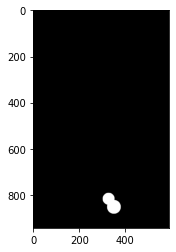

In [74]:
plt.imshow(cv2.imread(f'{root_path}\\{MIAS_PREPROCESSED_DATA_PATH}\\MASK\\mdb005.png'))

###### Analisis tamaños de las imagenes

In [27]:
pd.options.display.float_format = '{:,.2f}'.format

# Se obtienen las imagenes procesadas.
l = []
for path, db in zip([CBIS_DDSM_PREPROCESSED_DATA_PATH, INBREAST_PREPROCESSED_DATA_PATH, MIAS_PREPROCESSED_DATA_PATH], 
                    ['CBIS', 'InBreast', 'MIAS']):
    df = pd.DataFrame(search_files(file=f'{root_path}\\{path}\\FULL', ext='png', in_subdirs=False), columns=['FILEPATH'])
    df.loc[:, 'IMG_SIZE'] = df.FILEPATH.apply(lambda x: cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2GRAY).shape)
    df.loc[:, 'db'] = db
    df.loc[:, 'width'] = df.IMG_SIZE.str[1].astype(int)
    df.loc[:, 'height'] = df.IMG_SIZE.str[0].astype(int)
    l.append(df[['db', 'width', 'height']])

pd.concat(l).groupby('db').describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]).T.unstack(level=0)

db        CBIS          InBreast            MIAS       
         width   height    width   height  width height
count 1,473.00 1,473.00    88.00    88.00  69.00  69.00
mean  2,063.24 4,625.03 1,468.99 3,069.19 517.86 913.45
std     592.28   741.92   376.34   418.08 115.25  46.02
min     502.00 2,289.00   656.00 1,849.00 320.00 700.00
10%   1,321.40 3,717.60 1,020.50 2,567.30 363.00 856.20
20%   1,552.60 4,028.00 1,142.40 2,769.80 417.60 883.40
30%   1,721.20 4,194.60 1,241.30 2,863.60 444.00 904.00
40%   1,871.00 4,321.00 1,381.60 2,966.60 467.20 924.60
50%   2,028.00 4,585.00 1,461.00 3,048.00 514.00 943.00
60%   2,182.60 4,845.00 1,558.20 3,135.20 559.60 943.00
70%   2,332.00 4,968.00 1,641.20 3,289.60 586.00 943.00
80%   2,542.80 5,145.60 1,727.80 3,418.60 604.20 943.00
90%   2,843.80 5,707.40 1,927.20 3,757.00 656.80 943.00
max   5,016.00 6,363.00 2,597.00 3,757.00 870.00 943.00

###### Analisis tamaños de los ROIS

In [28]:
# Se obtienen los rois procesados.
l = []
for path, db in zip([CBIS_DDSM_PREPROCESSED_DATA_PATH, INBREAST_PREPROCESSED_DATA_PATH, MIAS_PREPROCESSED_DATA_PATH], 
                    ['CBIS', 'InBreast', 'MIAS']):
    df = pd.DataFrame(search_files(file=f'{root_path}\\{path}\\CROP\\CONF0', ext='png', in_subdirs=False), columns=['FILE'])
    df.loc[:, 'IMG_SIZE'] = df.FILE.apply(lambda x: cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2GRAY).shape)
    df.loc[:, 'db'] = db
    df.loc[:, 'width'] = df.IMG_SIZE.str[1].astype(int)
    df.loc[:, 'height'] = df.IMG_SIZE.str[0].astype(int)
    l.append(df[['db', 'width', 'height']])

pd.concat(l).groupby('db').describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9]).T.unstack(level=0)

db        CBIS          InBreast            MIAS       
         width   height    width   height  width height
count 1,553.00 1,553.00    94.00    94.00  72.00  72.00
mean    396.70   392.07   397.23   393.23 130.42 129.58
std     164.81   160.12   236.09   238.36  85.81  86.39
min      58.00   136.00    86.00    58.00  42.00  24.00
10%     236.00   238.00   153.60   156.00  56.00  50.60
20%     278.00   272.00   197.20   189.20  68.40  68.40
30%     307.20   300.00   225.80   231.80  80.00  80.00
40%     336.00   329.60   265.60   280.00  92.80  92.80
50%     364.00   360.00   347.00   321.00 107.00 109.00
60%     396.00   390.00   424.00   408.80 118.00 118.00
70%     434.00   432.00   518.60   505.20 134.00 134.00
80%     486.00   480.00   586.00   563.60 165.60 164.00
90%     596.00   594.00   641.00   702.80 255.80 255.80
max   2,130.00 1,594.00 1,130.00 1,180.00 474.00 474.00